In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
import sys
import subprocess
import os
import warnings
warnings.filterwarnings('ignore')
import joblib
from datetime import datetime
import time
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint
from mplfinance.original_flavor import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mpl_dates

#Define the 20cryptocurrencies to be downloaded
crypt_coins = "BTC,BNB,ETH,DOT,XRP,ADA,LTC,XLM,DASH,BCH,DOGE,AAVE,SOL,MIOTA,NEXO,ETC,XMR,WAVES,ICX,EOS"
ccoin_list = crypt_coins.split(",")  # ['BTC', ' BNB'...]
ccoin_dictionary = {coin:ccoin_list.index(coin) for coin in ccoin_list}

In [2]:
#Download the historical daily data of 20 different cryptocurrencies from Yahoo Finance API
#Load into a pandas dataframe and save into a csv file
df = pd.DataFrame()

for coin in ccoin_list:
    df2 = yf.Ticker(f"{coin}-USD").history(start='2019-01-01', end='2023-04-01', interval="1d")
    df2 = pd.DataFrame(df2)
    df2['crypto_name'] = coin
    df = df.append(df2)

df.reset_index()
df.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df.to_csv('crypto_coins.csv')

OSError: [Errno 30] Read-only file system: 'crypto_coins.csv'

In [5]:
df

Open         High          Low        Close  \
Date                                                                            
2019-01-01 00:00:00+00:00  3746.713379  3850.913818  3707.231201  3843.520020   
2019-01-02 00:00:00+00:00  3849.216309  3947.981201  3817.409424  3943.409424   
2019-01-03 00:00:00+00:00  3931.048584  3935.685059  3826.222900  3836.741211   
2019-01-04 00:00:00+00:00  3832.040039  3865.934570  3783.853760  3857.717529   
2019-01-05 00:00:00+00:00  3851.973877  3904.903076  3836.900146  3845.194580   
...                                ...          ...          ...          ...   
2023-03-27 00:00:00+00:00     1.141650     1.152075     1.074169     1.085785   
2023-03-28 00:00:00+00:00     1.085770     1.117376     1.074843     1.113626   
2023-03-29 00:00:00+00:00     1.113587     1.152687     1.110405     1.149492   
2023-03-30 00:00:00+00:00     1.149452     1.212325     1.142122     1.189886   
2023-03-31 00:00:00+00:00     1.189964     1.208636     1.165470     1.194862   

                               Volume crypto_name  year  month  
Date                                                            
2019-01-01 00:00:00+00:00  4324200990         BTC  2019      1  
2019-01-02 00:00:00+00:00  5244856836         BTC  2019      1  
2019-01-03 00:00:00+00:00  4530215219         BTC  2019      1  
2019-01-04 00:00:00+00:00  4847965467         BTC  2019      1  
2019-01-05 00:00:00+00:00  5137609824         BTC  2019      1  
...                               ...         ...   ...    ...  
2023-03-27 00:00:00+00:00   153739163         EOS  2023      3  
2023-03-28 00:00:00+00:00   141715591         EOS  2023      3  
2023-03-29 00:00:00+00:00   124265614         EOS  2023      3  
2023-03-30 00:00:00+00:00   227527350         EOS  2023      3  
2023-03-31 00:00:00+00:00   134751060         EOS  2023      3  

[29318 rows x 8 columns]

In [5]:
df.head()

In [5]:
# check for null values
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Volume         0
crypto_name    0
year           0
month          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29318 entries, 2019-01-01 00:00:00+00:00 to 2023-03-31 00:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         29318 non-null  float64
 1   High         29318 non-null  float64
 2   Low          29318 non-null  float64
 3   Close        29318 non-null  float64
 4   Volume       29318 non-null  int64  
 5   crypto_name  29318 non-null  object 
 6   year         29318 non-null  int64  
 7   month        29318 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 2.0+ MB


In [7]:
df.dtypes

Open           float64
High           float64
Low            float64
Close          float64
Volume           int64
crypto_name     object
year             int64
month            int64
dtype: object

In [8]:
#To print/check the number of rows and columns in the dataset
num_rows, num_cols = df.shape
print(f'Number of Rows: {num_rows} \nNumber of columns: {num_cols}')

Number of Rows: 29318 
Number of columns: 8


In [9]:
#Generate descriptive statistics of the numerical columns in the dataframe
df.describe()

Open          High           Low         Close        Volume  \
count  29318.000000  29318.000000  29318.000000  29318.000000  2.931800e+04   
mean    1367.836183   1402.467653   1329.915276   1368.582854  3.444997e+09   
std     6548.418118   6712.877730   6362.934359   6549.126626  9.034844e+09   
min        0.000000      0.001612      0.000000      0.001537  0.000000e+00   
25%        0.387802      0.401439      0.372863      0.387879  9.181640e+07   
50%        6.902272      7.209016      6.653437      6.918097  4.459476e+08   
75%      129.712509    134.283169    125.224962    129.688412  2.036085e+09   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

               year         month  
count  29318.000000  29318.000000  
mean    2020.719524      6.291289  
std        1.221275      3.525147  
min     2019.000000      1.000000  
25%     2020.000000      3.000000  
50%     2021.000000      6.000000  
75%     2022.000000      9.000000  
max     2023.000000     12.000000

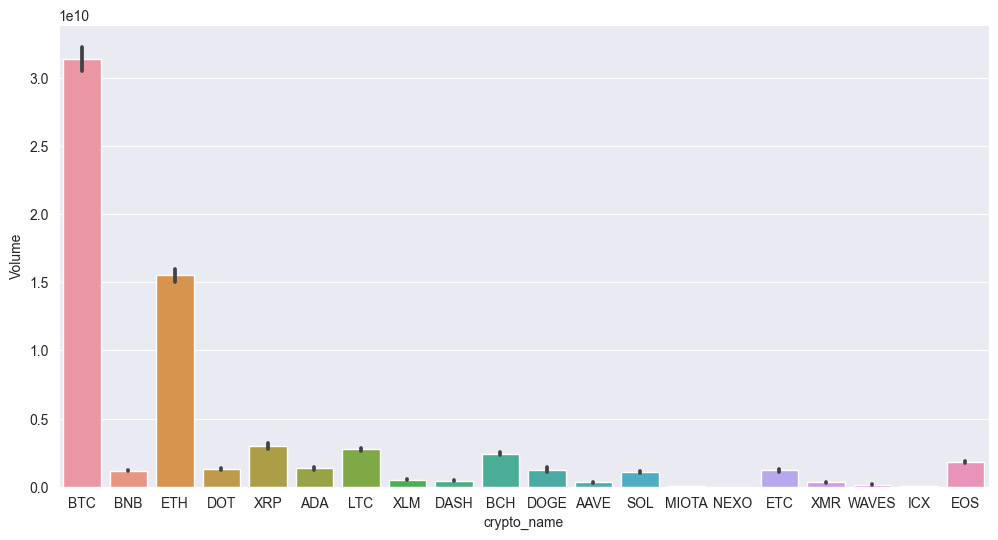

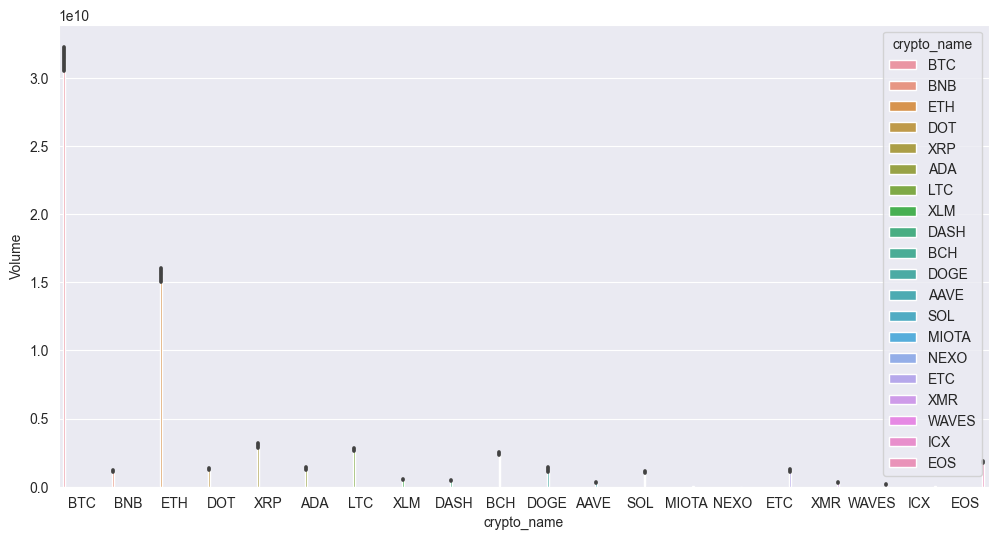

In [10]:
#Plot a bar chart to show the average trading volume for each cryptocurrency coin.
plt.figure(figsize=(12,6))
sns.barplot(x='crypto_name', y='Volume', data=df, estimator=np.mean)

plt.figure(figsize=(12,6))
sns.barplot(x='crypto_name', y='Volume', data=df, estimator=np.mean, hue='crypto_name')

fig = px.bar(df, x='crypto_name', y='Volume', title='Average Trading Volume per Cryptocurrency Coin')
fig.show()

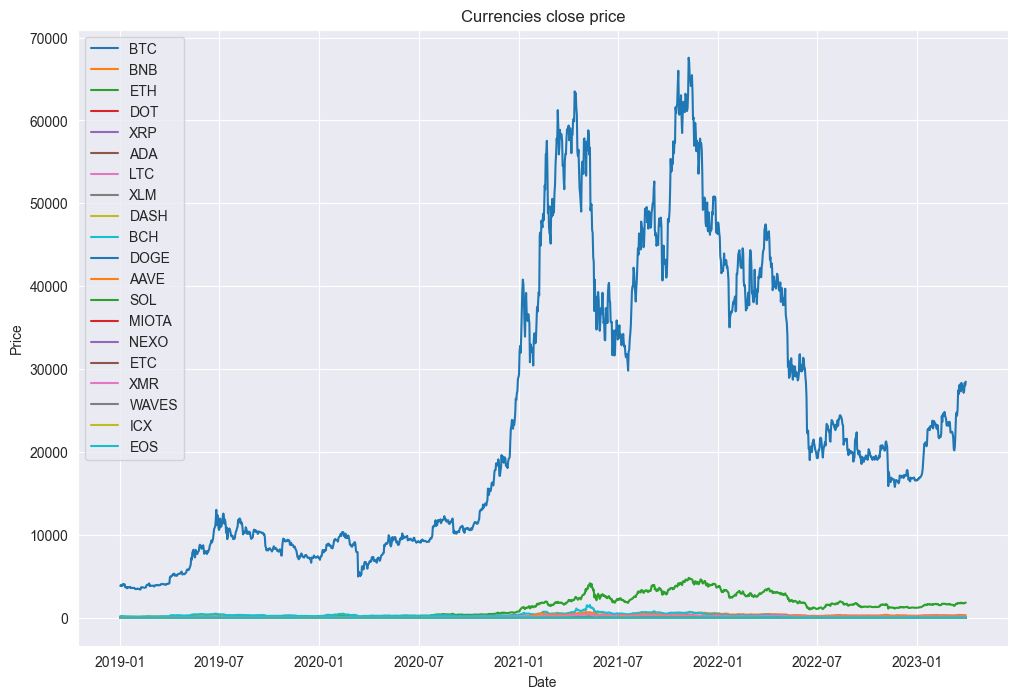

In [11]:
# To plot a single line chart with multiple lines, to show closing price data for all 20coins.
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for coin in ccoin_list:
    data = df[df["crypto_name"]==coin]
    ax.plot(data.index, data.Close, label=coin)

ax.set_title('Currencies close price')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

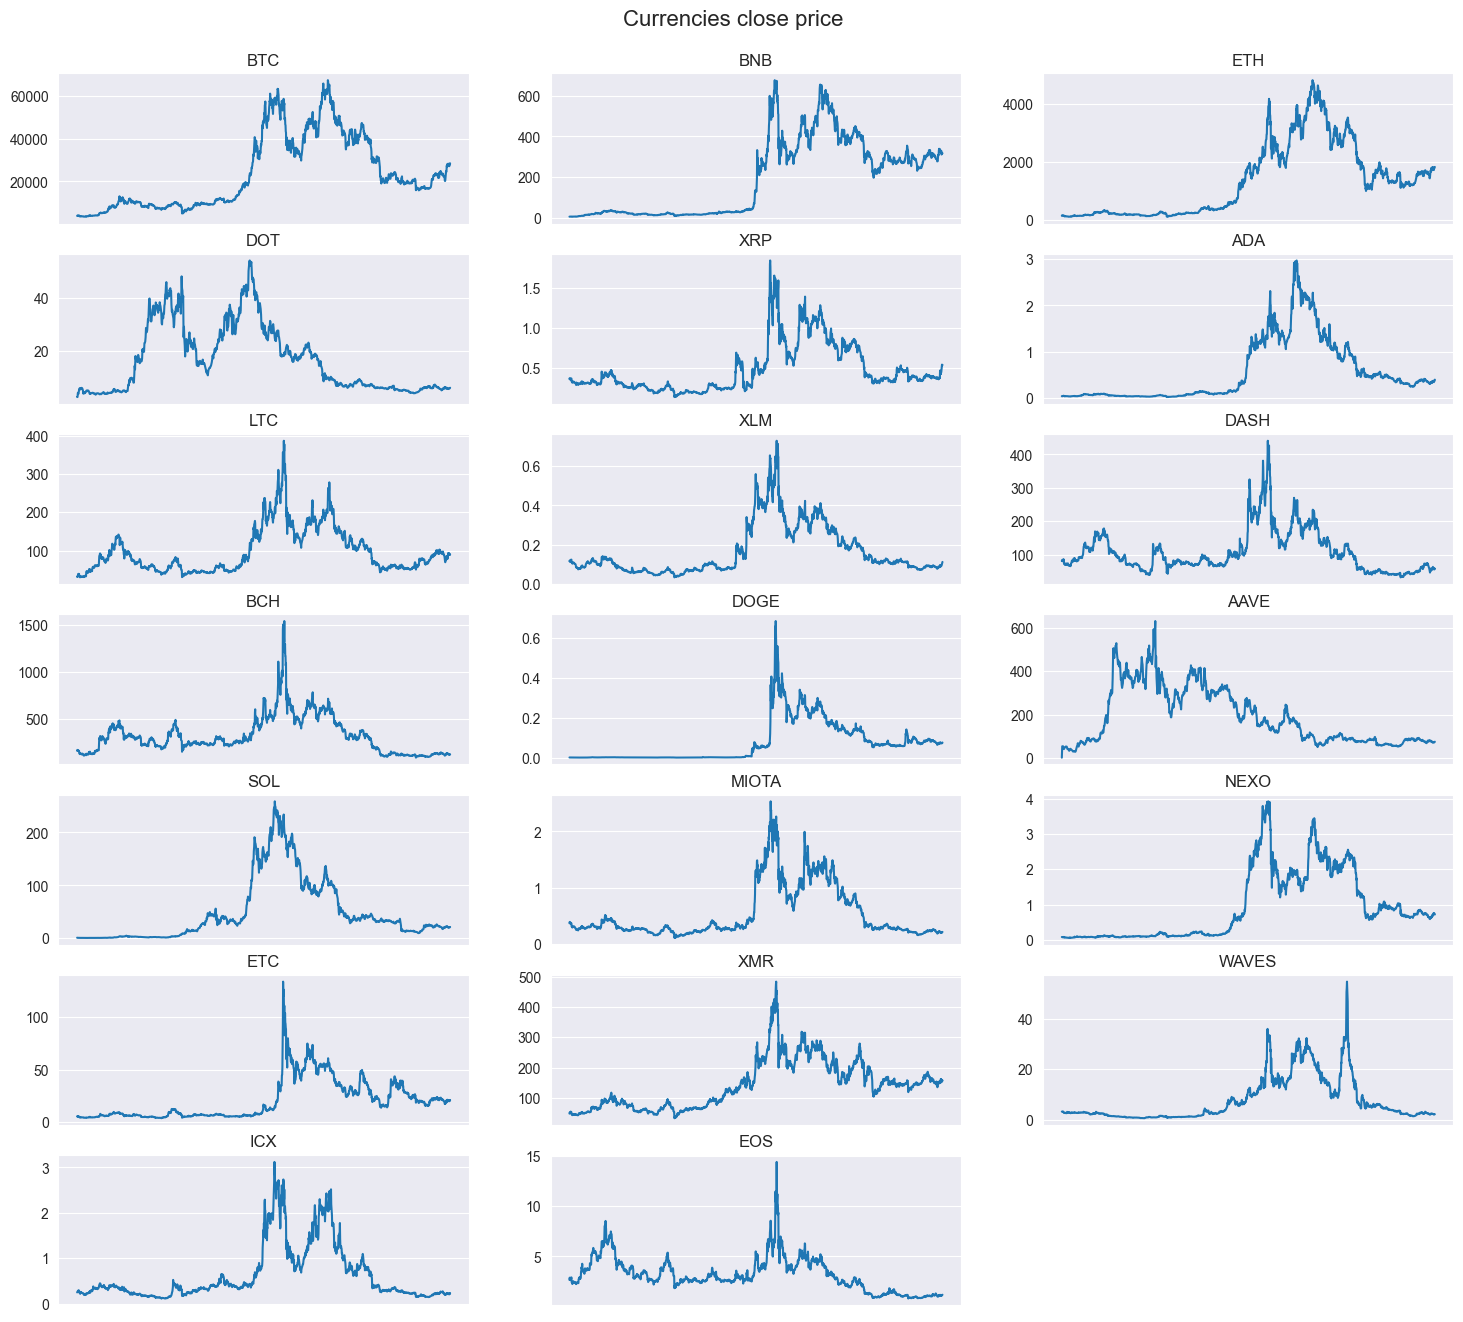

In [12]:
#Create a figure with subplot for each cryptocurrency
#plots the closing price data over time for each cryptocurrency
fig = plt.figure(figsize=(18,16))
fig.suptitle('Currencies close price', fontsize=16, y = 0.92)
for i, coin in enumerate(ccoin_list):
    data = df[df["crypto_name"]==coin]
    plt.subplot(7, 3, i+1)
    plt.plot(data.index, data.Close)
    plt.title(coin)
    plt.xticks([])
plt.show()

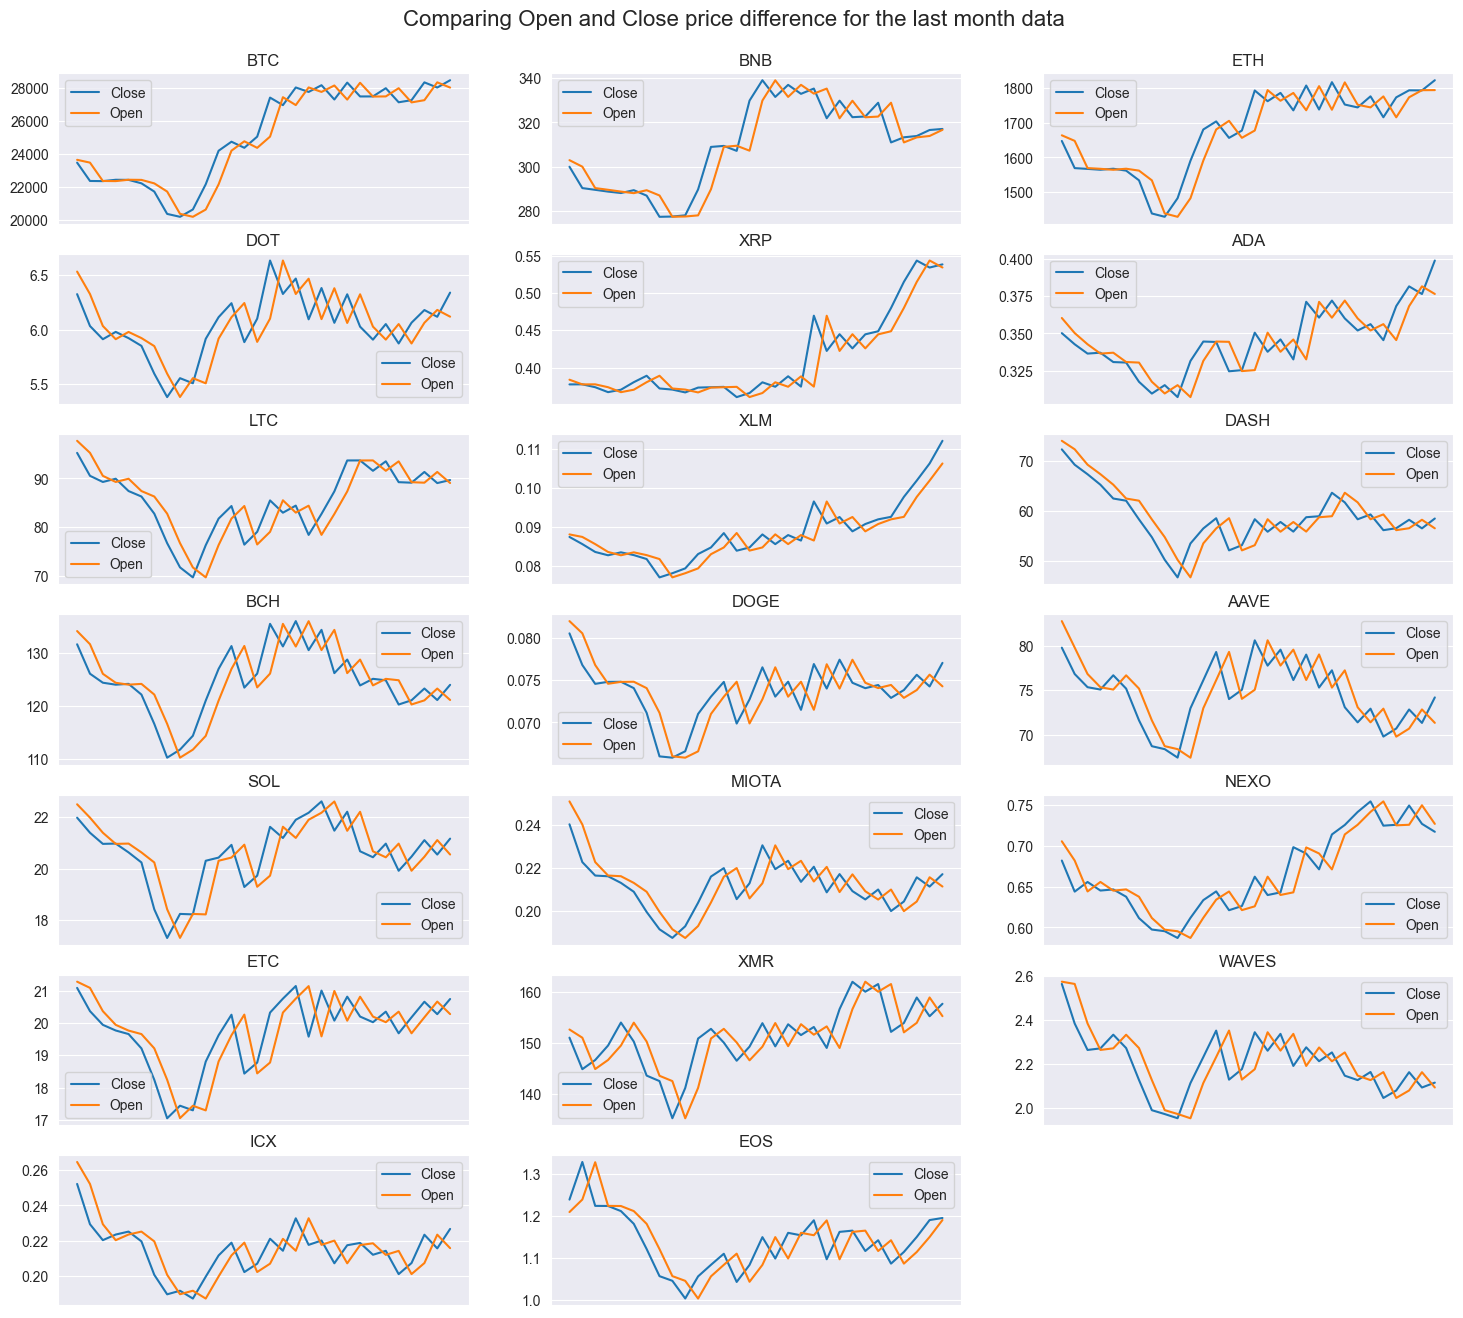

In [13]:
#To show a comparison of the open and close prices for the last 30 days of data for the respective cryptocurrency.
fig = plt.figure(figsize=(18,16))
fig.suptitle('Comparing Open and Close price difference for the last month data', fontsize=16, y = 0.92)
for i, coin in enumerate(ccoin_list):
    data = df[df["crypto_name"]==coin]
    plt.subplot(7, 3, i+1)
    plt.plot(data.index[-30:], data.Close[-30:], label="Close")
    plt.plot(data.index[-30:], data.Open[-30:], label="Open")
    plt.title(coin)
    plt.legend()
    plt.xticks([])
plt.show()

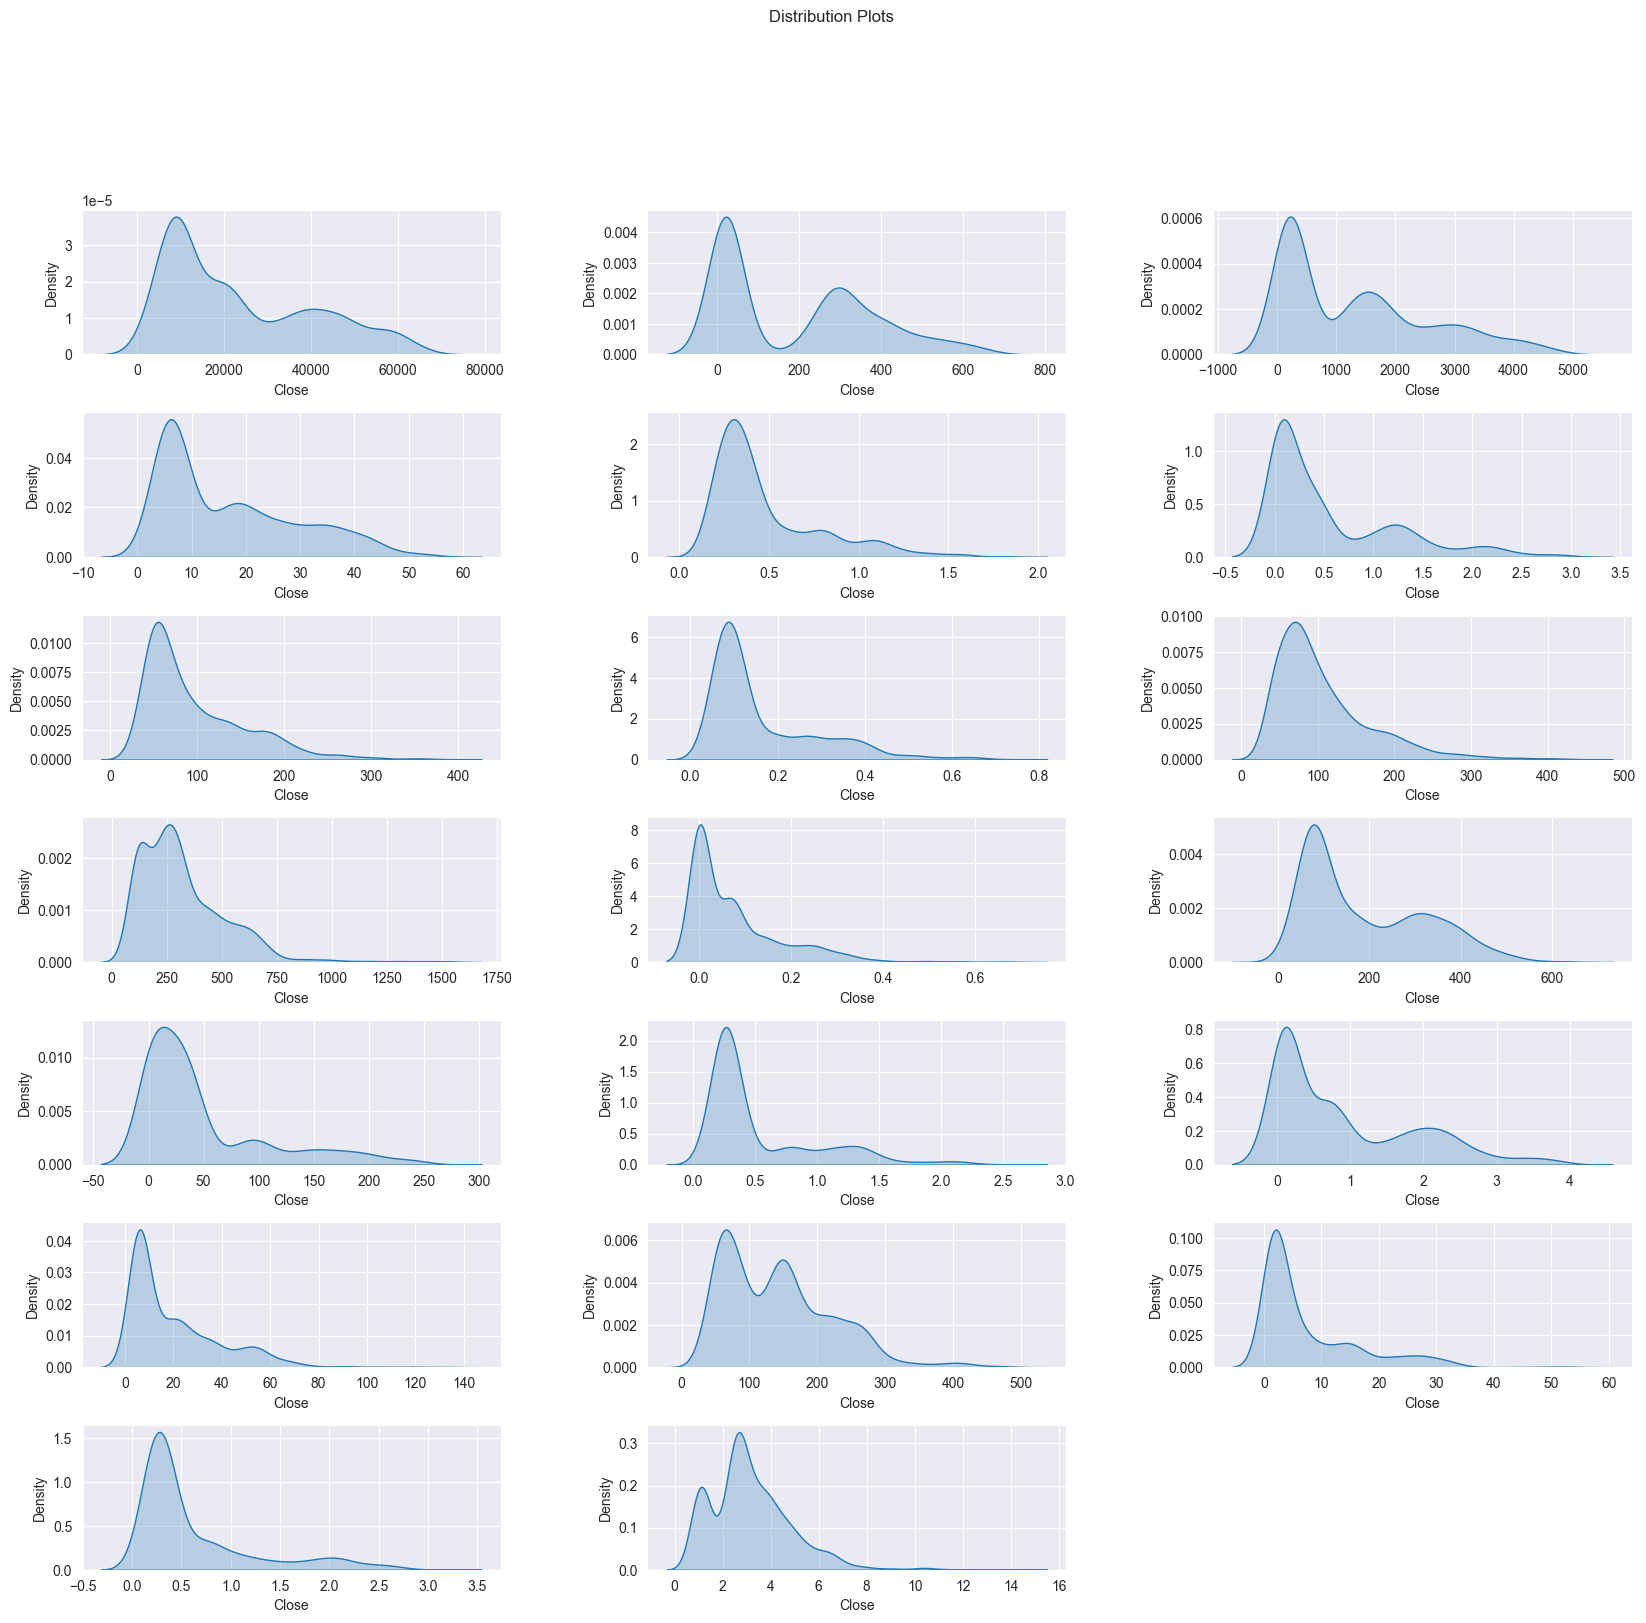

In [14]:
#plots the kernel density estimate (KDE) for the Close price distribution of each coin
plt.figure(figsize=(20,20))

for i, coin in enumerate(ccoin_list):
    data = df[df["crypto_name"]==coin]
    ax = plt.subplot(7, 3, i+1)
    sns.kdeplot(data = data, x = data.Close, palette="Purples", shade=True)
    plt.grid('on')

plt.subplots_adjust(wspace=0.35, bottom=0.2, hspace=0.4)
plt.suptitle("Distribution Plots")
plt.show()

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>],
       [<Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Volume'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>, <Axes: >, <Axes: >]],
      dtype=object)

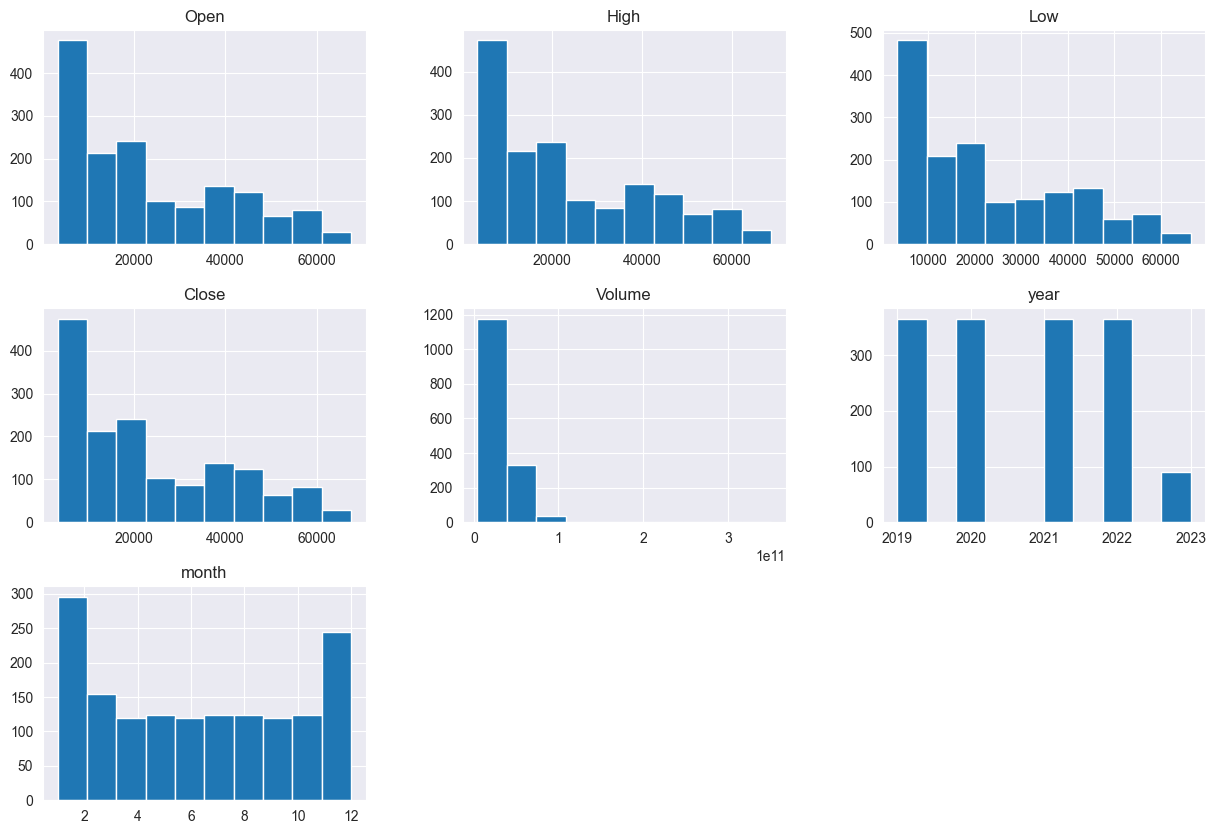

In [15]:
# slicing single coin for further analysis
#creates a histogram for the columns of the DataFrame coin_df that correspond to the single coin
coin_ = "BTC"
coin_df = df[df["crypto_name"]==coin_]
coin_df.hist(figsize=(15,10))

<Axes: >

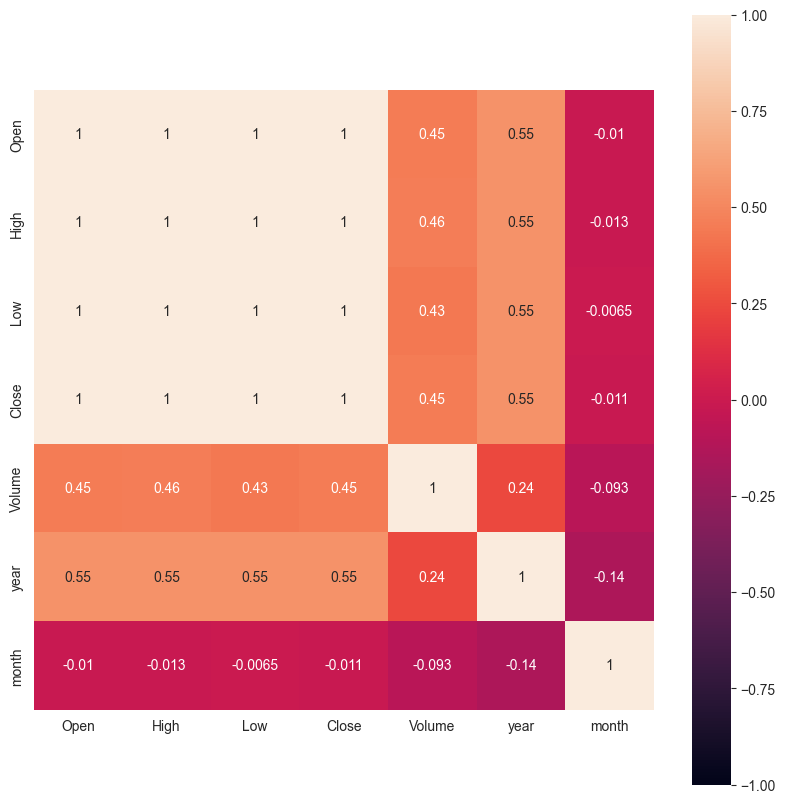

In [16]:
#Plot a correlation heatmap for the features
plt.figure(figsize = (10,10))
sns.heatmap(coin_df.corr(), vmin=-1.0, annot=True, square=True)

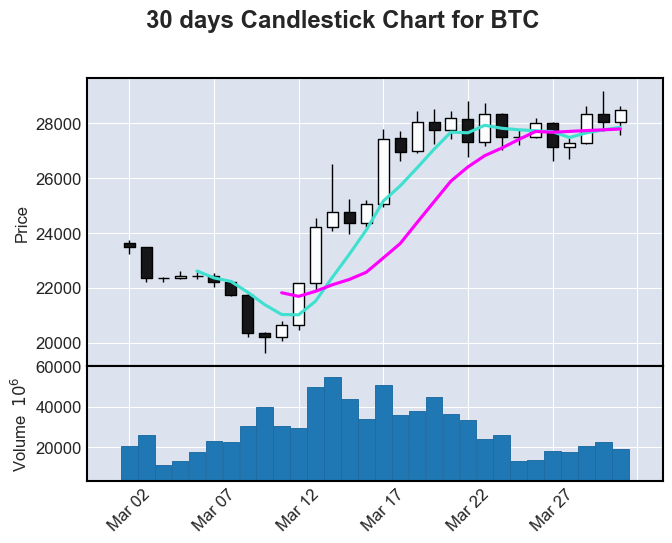

In [17]:
# Plot a candlestick chart with volume bars.
mpf.plot(coin_df[-30:], type='candle', volume=True, ylabel='Price', mav=(5,10),
         title=f'30 days Candlestick Chart for {coin_}')

30 days Scatter plot with average movement for single coin =>  BTC


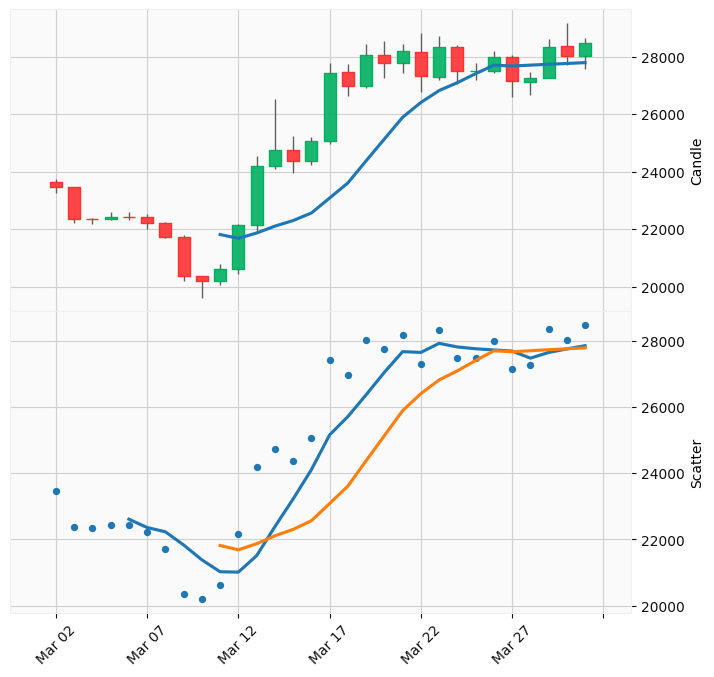

In [18]:
#Scatter plot to show 30days average movement for a single coin (BTC)
print("30 days Scatter plot with average movement for single coin => ", coin_)
ap = mpf.make_addplot(coin_df['Close'][-30:],panel=1,type='scatter',ylabel='Scatter',mav=(5,10))
mpf.plot(coin_df[-30:],mav=10,type='candle',ylabel='Candle',addplot=ap,panel_ratios=(1,1),
         figratio=(1,1),figscale=1.5,style='yahoo')

## Label encoding

In [19]:
# initialize label encoding
label_encoder = LabelEncoder()

# make a copy of the DataFrame
df_encoded = df.copy()

# fit and transform the "crypto_name" column
df_encoded["crypto_name_encoded"] = label_encoder.fit_transform(df_encoded["crypto_name"])

# display the first two rows
df_encoded.head(2)

Open         High          Low        Close  \
Date                                                                            
2019-01-01 00:00:00+00:00  3746.713379  3850.913818  3707.231201  3843.520020   
2019-01-02 00:00:00+00:00  3849.216309  3947.981201  3817.409424  3943.409424   

                               Volume crypto_name  year  month  \
Date                                                             
2019-01-01 00:00:00+00:00  4324200990         BTC  2019      1   
2019-01-02 00:00:00+00:00  5244856836         BTC  2019      1   

                           crypto_name_encoded  
Date                                            
2019-01-01 00:00:00+00:00                    4  
2019-01-02 00:00:00+00:00                    4

## Feature importance

In [20]:
# split the dataset into X and y ie train and test data
X = df_encoded.drop(['Close', 'crypto_name'], axis=1)
y = df_encoded['Close']

# create a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model
rf.fit(X, y)

# calculate feature importance
importance = rf.feature_importances_

# create a dataframe to display feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values('Importance', ascending=False)

# display the feature importance
print(feature_importance)


               Feature    Importance
1                 High  6.269278e-01
2                  Low  3.676911e-01
0                 Open  5.295035e-03
3               Volume  5.659720e-05
5                month  2.181124e-05
4                 year  7.278012e-06
6  crypto_name_encoded  3.763484e-07


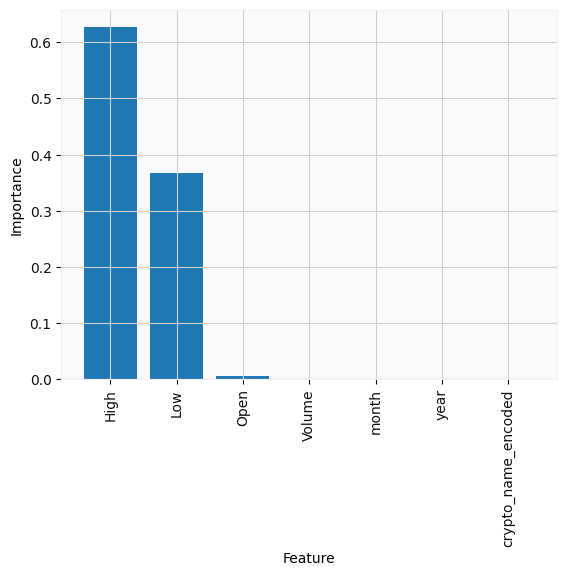

In [21]:
# Barchart to show the feature importance
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Feature scaling

In [22]:
#Initializing a MinMaxScaler object with feature range (0,1)
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0,1))
# Fitting the scaler on the encoded data containing the columns
scaler.fit(df_encoded[["Open", "High", "Low", "Close", "crypto_name_encoded"]])

# Defining a function to scale the data using the fitted scaler
def myScaler(data):
    global scaler
    data_ = data.copy()
    data_scaled_ = scaler.transform(data_)
    data_scaled_ = pd.DataFrame(data_scaled_, columns=data_.columns)
    data_scaled_.index = data_.index
    return data_scaled_

# Defining a function to inverse scale the data using the fitted scaler
def myInverseScale(data):
    global scaler
    # Inverse transforming the data using the scaler
    data_scaler_inverse = scaler.inverse_transform(data)
    # Converting the inverse transformed data into a DataFrame with the original column names and index
    data_scaler_inverse = pd.DataFrame(data_scaler_inverse, columns=data.columns)
    data_scaler_inverse.index = data.index
    return data_scaler_inverse

In [23]:
#Feature scaling to prepare the data for further analysis and prediction
# Select the columns to scale
to_scale = df_encoded[["Open", "High", "Low", "Close", "crypto_name_encoded"]]
# Call the custom scaling function to scale the selected columns
df_scaled = myScaler(to_scale)

In [24]:
df_scaled.head()

Open      High       Low     Close  \
Date                                                                
2019-01-01 00:00:00+00:00  0.055466  0.055981  0.055847  0.056885   
2019-01-02 00:00:00+00:00  0.056983  0.057392  0.057507  0.058363   
2019-01-03 00:00:00+00:00  0.058195  0.057213  0.057639  0.056784   
2019-01-04 00:00:00+00:00  0.056729  0.056199  0.057001  0.057095   
2019-01-05 00:00:00+00:00  0.057024  0.056766  0.057800  0.056909   

                           crypto_name_encoded  
Date                                            
2019-01-01 00:00:00+00:00             0.210526  
2019-01-02 00:00:00+00:00             0.210526  
2019-01-03 00:00:00+00:00             0.210526  
2019-01-04 00:00:00+00:00             0.210526  
2019-01-05 00:00:00+00:00             0.210526

In [25]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [26]:
# Selecting the features and target variable
X = df_scaled.drop('Close', axis=1)
y = df_scaled['Close']

# Split the data into training and testing sets with a train size of 70%
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=1)

#checking the shape of the train and test data to ensure correct splitting
#X_train.shape, X_test.shape, y_train.shape, y_test.shape
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (20522, 4)
Shape of X_test: (8796, 4)
Shape of y_train: (20522,)
Shape of y_test: (8796,)


In [27]:
# Fit the model on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [28]:
# To predict the target variable using the trained model & testing features
predicted = model.predict(X_test)

In [29]:
# To print the evaluation metrics of the random forest regression model
print(f'R-square: {r2_score(y_test, predicted)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predicted)}')
print(f'Mean Squared Error: {mean_squared_error(y_test, predicted)}')

R-square: 0.9993404417273684
Mean Absolute Error: 0.00036221472885564535
Mean Squared Error: 6.255140147339605e-06


In [30]:
# Add the predicted Close values to the test set
X_test["Close"] = predicted
# Keep only the required columns and re-order them
X_test = X_test[["Open", "High", "Low", "Close", "crypto_name_encoded"]]
# Inverse scale the predicted data to get the actual prices
predicted_inversed = myInverseScale(X_test)

In [31]:
# Set the "Close" column of the test dataset to the actual test values
X_test["Close"] = y_test

# Select the relevant columns
X_test = X_test[["Open", "High", "Low", "Close", "crypto_name_encoded"]]

# Apply the myInverseScale function to the selected columns
test_inversed = myInverseScale(X_test)

In [32]:
# Add the predicted Close prices to the test data (in original scale)
test_inversed["predicted"] = predicted_inversed["Close"]

<Axes: xlabel='Date'>

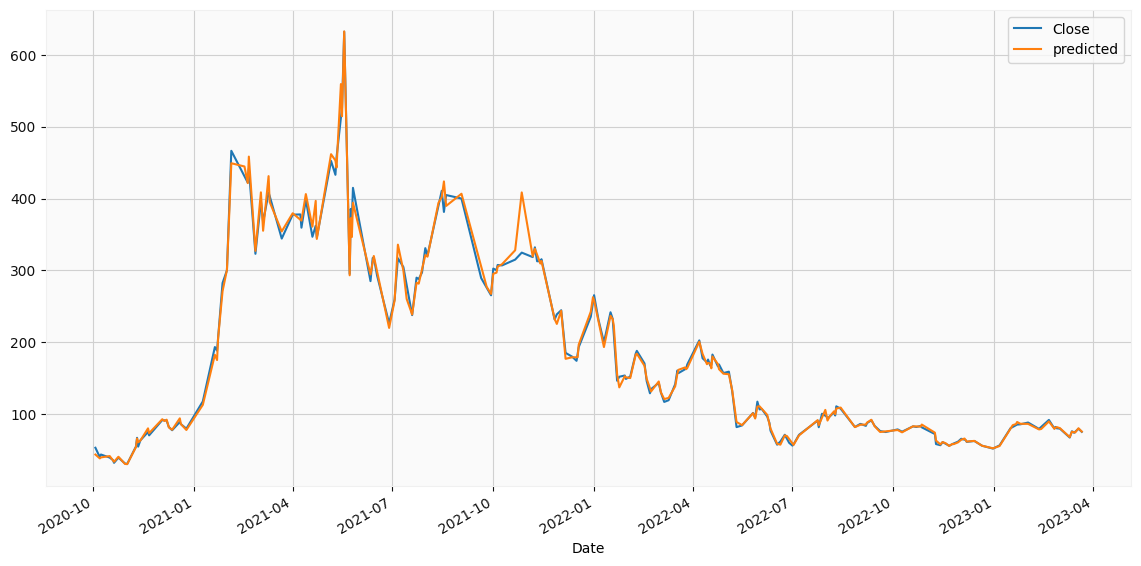

In [33]:
# Plot the actual and predicted closing price of the cryptocurrency encoded as 0, using the data stored in the test_inversed dataframe and
test_inversed[test_inversed["crypto_name_encoded"]==0][["Close", "predicted"]].plot(figsize=(14, 7))

## Hyperparameter fine-tunning

In [34]:
# Create a RandomForestRegressor object
rf = RandomForestRegressor()

# Define the hyperparameter space
param_dist = {'n_estimators': randint(1, 50),
              'max_depth': randint(1, 20),
              'min_samples_split': randint(2, 20),
              'min_samples_leaf': randint(1, 10),'bootstrap': [True, False],'max_features': ['auto', 'sqrt']}

# Define the rolling-window cross-validation split
tscv = TimeSeriesSplit(n_splits=5)

# Create a RandomizedSearchCV object with rolling-window cross-validation
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=tscv,
                                   random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X, y)

# Print the best parameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


Best Parameters:  {'bootstrap': True, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 26}
Best Score:  0.9977293774044572


In [35]:
X = df_scaled.drop('Close', axis=1)
y = df_scaled['Close']

# train-test spliting of dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=1)

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

model = RandomForestRegressor(bootstrap=True, max_depth=15, max_features='auto',
                              min_samples_leaf=4, min_samples_split=6, n_estimators=12)
model.fit(X_train, y_train)

predicted = model.predict(X_test)

print(f'R-square: {r2_score(y_test, predicted)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predicted)}')
print(f'Mean Squared Error: {mean_squared_error(y_test, predicted)}')

R-square: 0.9993030949944373
Mean Absolute Error: 0.0003749902023520695
Mean Squared Error: 6.609330304938685e-06


## Save model and others

In [36]:
# Save the trained model, scaler and label encoder to disk. to be loaded and used to make predictions on new data.
joblib.dump(model,'model.joblib')
joblib.dump(scaler,'scaler.joblib')
joblib.dump(label_encoder,'label_encoder.joblib')

['label_encoder.joblib']

## Model loading and predicting

In [37]:
# loads the saved scaler, label encoder, and model from their respective joblib files.
scaler_ = joblib.load('scaler.joblib')
label_encoder_ = joblib.load('label_encoder.joblib')
model_ = joblib.load('model.joblib')

In [38]:
# Obtain historical price data for a given cryptocurrency,return the columns in a dataframe with two parameters
def getcoindata(coin_name_, interval_="1d"):
    df2 = yf.Ticker(f"{coin_name_}-USD").history(start='2023-01-01', end=str(datetime.today().date()), interval=interval_)
    df2 = pd.DataFrame(df2)
    df2['crypto_name'] = coin_name_

    df2.reset_index()
    df2.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)
    return df2

def myScaler_prod(data):
    # Declare that the function will use the global variable "scaler_"
    global scaler_
    # Create a copy of the input data to avoid modifying it
    data_ = data.copy()
    # Scale the numerical columns of the input data using the saved scaler object
    data_scaled_ = scaler_.transform(data_)
    # Convert the scaled data into a pandas DataFrame with the same columns and index as the input data
    data_scaled_ = pd.DataFrame(data_scaled_, columns=data_.columns)
    data_scaled_.index = data_.index
    # Return the scaled data as a pandas DataFrame
    return data_scaled_

# To get the original values of the scaled data to better interpret the model predictions.
def myInverseScale_prod(data):
    global scaler_
    data_scaler_inverse = scaler_.inverse_transform(data)
    data_scaler_inverse = pd.DataFrame(data_scaler_inverse, columns=data.columns)
    data_scaler_inverse.index = data.index
    return data_scaler_inverse

In [39]:
def execute_program(coin="BTC", time_string="1d"):
    # fetch data
    df_test = getcoindata(coin_name_=coin, interval_=time_string)

    # label encoding
    df_test["crypto_name_encoded"] = label_encoder_.transform(df_test["crypto_name"])

    # scale
    to_scale_ = df_test[["Open", "High", "Low", "Close", "crypto_name_encoded"]]
    df_scaled_ = myScaler_prod(to_scale_)

    # predict
    predicted_ = model_.predict(df_scaled_[["Open", "High", "Low", "crypto_name_encoded"]])

    # inverse scale
    inverse_predicted = df_scaled_.copy()
    inverse_predicted["Close"] = predicted_
    inverse_predicted = myInverseScale_prod(inverse_predicted[["Open", "High", "Low", "Close", "crypto_name_encoded"]])

    # merge
    df_test["predicted"] = inverse_predicted["Close"]
    
    # return dataset
    return df_test

In [40]:
# Loads saved model, scaler, and label encoder and uses them to make predictions on future price movements of cryptocurrencies
execute_program().tail()

Open          High           Low  \
Date                                                                  
2023-05-13 00:00:00+00:00  26807.769531  27030.482422  26710.873047   
2023-05-14 00:00:00+00:00  26788.974609  27150.976562  26661.355469   
2023-05-15 00:00:00+00:00  26931.384766  27646.347656  26766.097656   
2023-05-16 00:00:00+00:00  27171.513672  27299.304688  26878.947266   
2023-05-17 00:00:00+00:00  27035.470703  27465.927734  26600.144531   

                                  Close       Volume crypto_name  \
Date                                                               
2023-05-13 00:00:00+00:00  26784.078125   9999171605         BTC   
2023-05-14 00:00:00+00:00  26930.638672  10014858959         BTC   
2023-05-15 00:00:00+00:00  27192.693359  14413231792         BTC   
2023-05-16 00:00:00+00:00  27036.650391  12732238816         BTC   
2023-05-17 00:00:00+00:00  27398.802734  15140006925         BTC   

                           crypto_name_encoded     predicted  
Date                                                          
2023-05-13 00:00:00+00:00                    4  26630.152232  
2023-05-14 00:00:00+00:00                    4  26630.152232  
2023-05-15 00:00:00+00:00                    4  26989.707263  
2023-05-16 00:00:00+00:00                    4  27307.846477  
2023-05-17 00:00:00+00:00                    4  26845.262520

In [41]:
# replace the last close price with the predicted one
replaced_ = execute_program()
replaced_.at[replaced_.index[-1], 'Close'] = replaced_.iloc[-1]["predicted"]
replaced_.tail()

Open          High           Low  \
Date                                                                  
2023-05-13 00:00:00+00:00  26807.769531  27030.482422  26710.873047   
2023-05-14 00:00:00+00:00  26788.974609  27150.976562  26661.355469   
2023-05-15 00:00:00+00:00  26931.384766  27646.347656  26766.097656   
2023-05-16 00:00:00+00:00  27171.513672  27299.304688  26878.947266   
2023-05-17 00:00:00+00:00  27035.470703  27465.927734  26600.144531   

                                  Close       Volume crypto_name  \
Date                                                               
2023-05-13 00:00:00+00:00  26784.078125   9999171605         BTC   
2023-05-14 00:00:00+00:00  26930.638672  10014858959         BTC   
2023-05-15 00:00:00+00:00  27192.693359  14413231792         BTC   
2023-05-16 00:00:00+00:00  27036.650391  12732238816         BTC   
2023-05-17 00:00:00+00:00  26845.262520  15140006925         BTC   

                           crypto_name_encoded     predicted  
Date                                                          
2023-05-13 00:00:00+00:00                    4  26630.152232  
2023-05-14 00:00:00+00:00                    4  26630.152232  
2023-05-15 00:00:00+00:00                    4  26989.707263  
2023-05-16 00:00:00+00:00                    4  27307.846477  
2023-05-17 00:00:00+00:00                    4  26845.262520

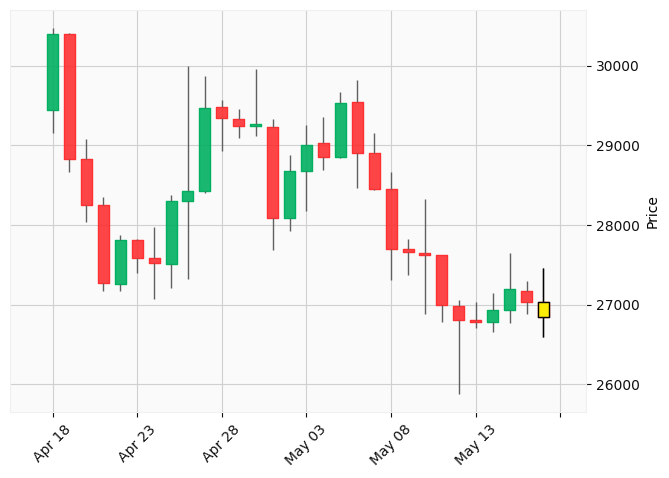

In [42]:
# Load some sample data
data = replaced_.copy()

# Customize market colors, and place inside style you intend to use:
mc = mpf.make_marketcolors(up='yellow',down='yellow')
s  = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)

# Create an all `nan` values dataframe, same size, and same index as the first:
nans = [float('nan')]*len(data)
cdf = pd.DataFrame(dict(Open=nans,High=nans,Low=nans,Close=nans),index=data.index)

# Copy in the specific candles that you want to color:
cdf.loc[str(data.tail(1).index[0])] = data.loc[str(data.tail(1).index[0])]
cdf
# Call `mpf.plot()` twice with the two dataframes and two styles:
fig, ax1 = mpf.plot(data[-30:],type='candle',style='yahoo',returnfig=True)
mpf.plot(cdf[-30:],type='candle',style=s,ax=ax1[0])